## **ONLINE stage**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3955/3115343983.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_3955/3115343983.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### MATRICES LOADING

In [2]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]

#### SELECTION OF THE FULL ORDER PARAMETERS 

In [3]:
TIME_DELTA = 10000
#FISSION_RATE = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(1))
FISSION_RATE = 3e19
FISSION_HEAT = 7.27E-18                  #[K/fissions]    = q'''/(rho Cp)            
FISSION_YIELD = 0.24E+00                
SOURCE_T = FISSION_RATE * FISSION_HEAT   
SOURCE_C = FISSION_RATE * FISSION_YIELD  
ALPHA_T = 5.00E-07                       #[m^2 / s]   # = k/(rho Cp)
#LENGTH = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(1))
LENGTH = 1e-03
#RADIUS = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(1))
RADIUS = 1e-05
#T_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(1))
T_BC = 2000
print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "f/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 f/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m



#### CONSTRUCTION OF THE LHS AND RHS

In [4]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [5]:
print(WW)

[1.03483679e-16 2.13899491e-17 5.64282052e-17 3.34541840e-17
 8.48893704e-17 2.54543157e-17]


### FORWARD EULER

In [6]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

6.0853752761455435e+22
1.1645730546768368e+23
1.6824175312627667e+23
2.16931009149449e+23
2.6297981934010114e+23
3.067080084734396e+23
3.483566284155347e+23
3.8811605149212166e+23
4.261417924840281e+23
4.6256419628876855e+23
4.9749474438593e+23
5.310303562773423e+23
5.632564333948289e+23
5.942490784887706e+23
6.240767544786966e+23
6.528015505635452e+23
6.804801660639781e+23
7.07164686952246e+23
7.329032072723122e+23
7.57740332642248e+23
7.817175928649853e+23
8.04873783625533e+23
8.272452522631473e+23
8.488661390086166e+23
8.697685824391951e+23
8.899828959427538e+23
9.095377205067112e+23
9.284601580244917e+23
9.467758884501233e+23
9.645092734642926e+23
9.816834487949804e+23
9.983204069276093e+23
1.014441071617597e+24
1.0300653653626042e+24
1.0452122707879903e+24
1.059899886735634e+24
1.074145479714763e+24
1.0879655312670339e+24
1.1013757817116065e+24
1.1143912706653182e+24
1.1270263746751217e+24
1.139294842252157e+24
1.1512098265572494e+24
1.162783915954657e+24
1.1740291626233477e+24
1.

#### COMPARISON WITH THE FULL ORDER MODEL

1.8465345974570977e-05


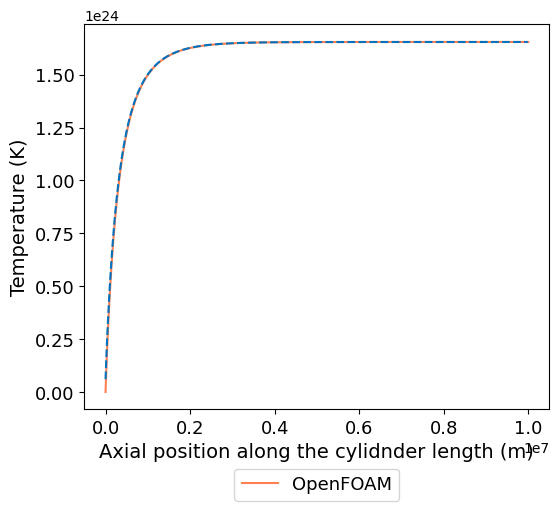

In [16]:
full_order= pd.read_csv('../0. full order/Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv')

error = np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1]
print(error)

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(full_order.iloc[:, 0], full_order.iloc[:, 1], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(full_order.iloc[:-1, 0],reconstructed_solution , '--',label = '', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)
